In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import roots_legendre
from scipy.integrate import quad_vec
import pyccl as ccl

from SSLimPy.interface import sslimpy
from SSLimPy.cosmology import cosmology
from SSLimPy.cosmology import halo_model
from SSLimPy.LIMsurvey import higher_order
from SSLimPy.utils.utils import linear_interpolate, addVectors

import SSLimPy.LIMsurvey.power_spectrum as sps
import SSLimPy.cosmology.astro as sastro
import SSLimPy.LIMsurvey.covariance as scov
import SSLimPy.interface.survey_specs as sss

In [2]:
import seaborn
seaborn.set_theme(rc={'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black',})
C = seaborn.color_palette("Paired")
C

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [3]:
envkey = "OMP_NUM_THREADS"
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(12)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  12


In [4]:
cosmo_dict = {
    "h": 0.7,
    "ns": 0.96,
    "sigma8": 0.82,
    "Omegab": 0.05,
    "Omegam": 0.32,
    "mnu": 0.06,
}

halo_dict = {
    "hmf_model":"ST",
    "bias_model": "b1",
    "nR" : 256,
    "Rmin": 1e-3 * u.Mpc,
    "Rmax": 1e3 * u.Mpc,
    "bloating": "Mead20",
}

In [5]:
settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : True,
            "Smooth_window" : False,
            "nk":100,
            "kmax": 50*u.Mpc**-1,
            "kmin": 1e-3*u.Mpc**-1,
            "Smooth_resolution": False,
            }

sslimpy.sslimpy(settings_dict=settings)

  █████   █████  █       █            █████   █    █ 
 █     █ █     █ █            █   █   █    █  █   █  
 █       █       █     ███   █ █ █ █  █    █   █ █   
  █████   █████  █       █   █  █  █  █████     █    
       █       █ █       █   █     █  █        █     
 █     █ █     █ █       █   █     █  █       █      
  █████   █████  █████ █████ █     █  █      █       

#---------------------------------------------------#


In [6]:
s_cosmo = cosmology.CosmoFunctions(cosmopars=cosmo_dict)
s_halo = halo_model.HaloModel(s_cosmo, halo_dict)

k = s_halo.k
print(np.min(k), np.max(k))

0.0010577432818586437 1 / Mpc 47.41174462620966 1 / Mpc


In [7]:
survey_specs = sss.SurveySpecifications(dict(), s_cosmo)
astro = sastro.AstroFunctions(s_halo, survey_specs)
pobs = sps.PowerSpectra(astro)
cov = scov.nonGuassianCov(pobs)

In [8]:
k = s_halo.k
Pk = s_cosmo.matpow(k, 0)

In [9]:
args = (0.0010577432818586437, 0.0010577432818586437, -0.9681602395076261, 0.9681602395076261,1, -0.2, 0.2, -1.2, 0.4, 2, 0.4, 0.7, 0, 0,)
higher_order.integrand_4h(3.013364382014699, *args, k.value, Pk.value)

-411113922160516.5

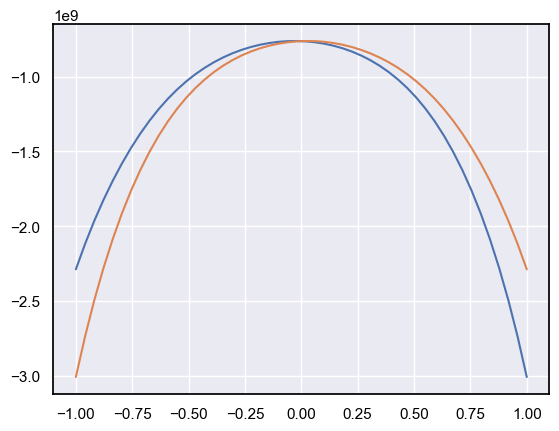

In [10]:
mu1 = np.linspace(-1, 1)
phis = np.linspace(-np.pi, np.pi)

phiintegrnd1 = np.empty_like(phis)
phiintegrnd2 = np.empty_like(phis)
I1 = np.zeros_like(mu1)
I2 = np.zeros_like(mu1)

for im, mi in enumerate(mu1):
    args = (0.4885185780734908, 0.7451451590319873, 0.7, mi, 1, -0.2, 0.2, -1.2, 0.4, 2, 0.4, 0.7, 0, 0,)
    args2 = (0.4885185780734908, 0.7451451590319873, -0.7, mi, 1, -0.2, 0.2, -1.2, 0.4, 2, 0.4, 0.7, 0, 0,)
    
    for ip, pi in enumerate(phis):
        phiintegrnd1[ip] = higher_order.integrand_4h(pi, *args, k.value, Pk.value)
        phiintegrnd2[ip] = higher_order.integrand_4h(pi, *args2, k.value, Pk.value)
    I1[im] = np.trapz(phiintegrnd1, phis)/(2 * np.pi)
    I2[im] = np.trapz(phiintegrnd2, phis)/(2 * np.pi)


plt.plot(mu1, I1)
plt.plot(mu1, I2)

In [11]:
args = dict(b1=1, b2=0, b3=0, bG2=0, bG3=0, bdG2=0, bDG2=0, f=0, sigma_parr=0, sigma_perp=0)
a = cov.integrate_4h(args=args, eps=1e-2)

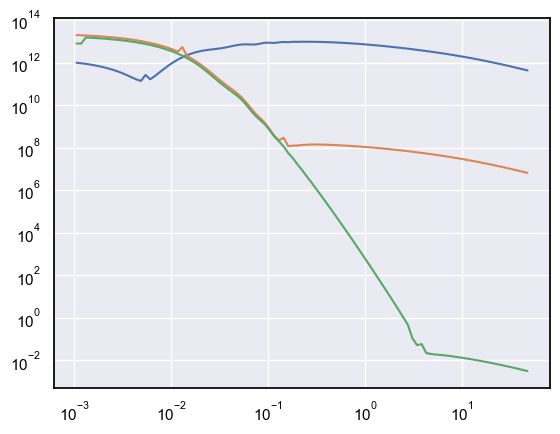

In [12]:
plt.loglog(k, -a[:, 15, 0, 0])
plt.loglog(k, -a[:, 45, 0, 0])
plt.loglog(k, -a[:, 75, 0, 0])

# Further tests

In [13]:
Omega_c = s_cosmo.Omega(0, "clustering") - 0.05
cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=0.05, h=0.7, sigma8=0.82, n_s=0.96)

cM = ccl.halos.ConcentrationDiemer15()
nM = ccl.halos.MassFuncSheth99(mass_def=ccl.halos.MassDef200c, mass_def_strict=False)
bM = ccl.halos.HaloBiasSheth99(mass_def=ccl.halos.MassDef200c, mass_def_strict=False)
pM = ccl.halos.HaloProfileNFW(mass_def=ccl.halos.MassDef200c, concentration=cM, fourier_analytic=True)

hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM)

Linear power spectra

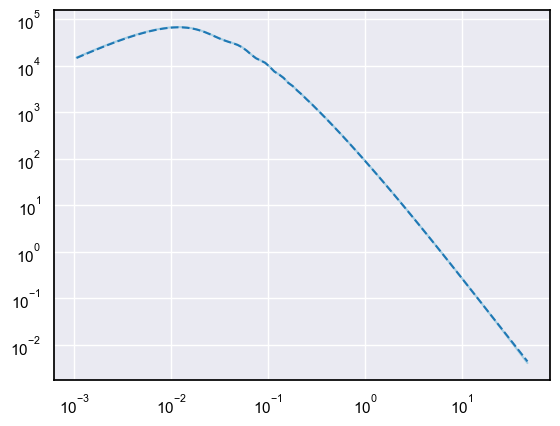

In [14]:
linpk_SL = s_cosmo.matpow(k, 0, nonlinear=False, tracer="clustering")
linpk_CC = ccl.linear_matter_power(cosmo, k.value, 1)

colors = iter(C)

plt.loglog(k, linpk_SL, c= next(colors))
plt.loglog(k, linpk_CC, c= next(colors), ls="--")

Extrapolation

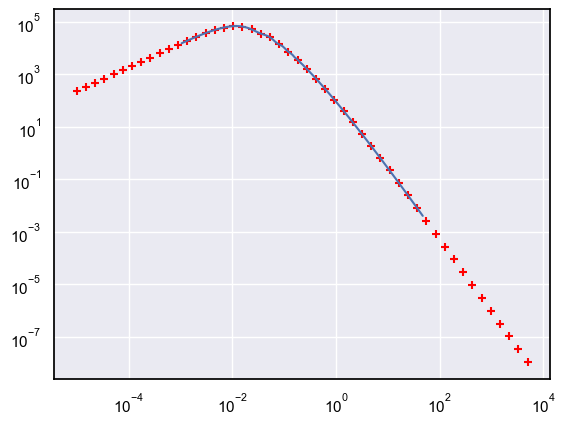

In [15]:
ktest = np.geomspace(1e-5, 50e2)
ptest = np.exp(linear_interpolate(np.log(k.value), np.log(linpk_SL.value), np.log(ktest)))
plt.loglog(k, linpk_SL)
plt.scatter(ktest, ptest, c="red", marker="+")

# Star Terms

SSLimPy

In [16]:
n_Num = 50
xi, wi = roots_legendre(n_Num)

In [17]:
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):

            # Compute over all permutations of the 1113 diagrams
            X_SL[ik1, ik2, imu] = higher_order.vF3(k1i.value, 1.0, 0.0, k1i.value, -1.0, np.pi, k2i.value, xi[imu], 0.0)
X_SL = 12 * np.sum(X_SL * wi, axis=-1)

In [44]:
T_3111_SL = X_SL * linpk_SL[:, None]**2 * linpk_SL[None, :]
T_3111_SL += T_3111_SL.T

In [45]:
T_3111_SL = T_3111_SL * 1/(4*np.pi)**2 / 6

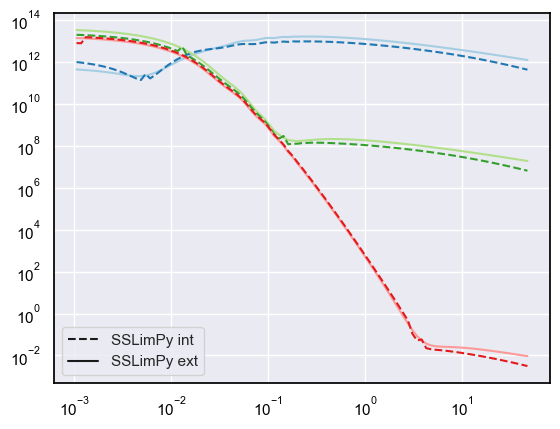

In [46]:
colors = iter(C)

plt.loglog(k, -T_3111_SL[:,15], c=next(colors))
plt.loglog(k, -a[:,15, 0, 0], c=next(colors), ls="--")
plt.loglog(k, -T_3111_SL[:,45], c=next(colors))
plt.loglog(k, -a[:,45, 0, 0], c=next(colors), ls="--")
plt.loglog(k, -T_3111_SL[:,75], c=next(colors))
plt.loglog(k, -a[:,75, 0, 0], c=next(colors), ls="--")

plt.loglog([],[], "k--", label="SSLimPy int")
plt.loglog([],[], "k-", label="SSLimPy ext")
plt.legend()

Pyccl

In [24]:
def funcT_3111_CC(cosmo: ccl.Cosmology):
    k_use = k.value
    pk2d = cosmo.get_linear_power()

    kk = k_use[None, :]
    kp = k_use[:, None]

    def get_X():
        k = kk
        r = kp / k

        def integ(theta):
            cth = np.cos(theta)
            kr2 = k ** 2 + kp ** 2 + 2 * k * kp * cth
            kr = np.sqrt(kr2)
            intd = (5 * r + (7 - 2*r**2)*cth) / (1 + r**2 + 2*r*cth) * \
                   (3/7. * r + 0.5 * (1 + r**2) * cth + 4/7. * r * cth**2)
            # When kr = 0, r = 1 and intd = 0
            intd[np.where(kr == 0)] = 0
            return intd

        isotropized_integ = \
            quad_vec(integ, 0, np.pi)[0] / np.pi

        X = -7./4. * (1 + r**2) + isotropized_integ

        return X

    X = get_X()
    pk = pk2d(k_use,1)[None, :]

    t1113 = 4/9. * pk**2 * pk.T * X
    t1113 += t1113.T
    return t1113, X

In [25]:
T_3111_CC, X = funcT_3111_CC(cosmo)
X = X * 4/ 9

In [28]:
n_Num = 50
xi, wi = roots_legendre(n_Num)

In [29]:
Pkr = np.empty((*k.shape, *k.shape, n_Num))
F2 = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k.value):
    for ik2, k2i in enumerate(k.value):
        for imu, mui in enumerate(xi):
            kr, mur, phr = addVectors(k1i, 1.0, 0.0, k2i, xi[imu], 0.0)
            if not np.isclose(kr, 0.0):
                Pkr[ik1, ik2, imu] = np.exp(
                    linear_interpolate(
                        np.log(k.value),
                        np.log(linpk_SL.value),
                        np.log([kr])
                    )[0]
                )
                F2[ik1, ik2, imu] = higher_order.vF2(k1i, 1, 0.0, kr, -mur, phr+np.pi)

            else:
                Pkr[ik1, ik2, imu] = 0
                F2[ik1, ik2, imu] = 13./28.

P4A_SL_th = Pkr * F2**2
P4X_SL_th = Pkr * F2 * np.transpose(F2, (1,0,2))

P4A_SL = np.sum(wi * P4A_SL_th, axis = -1)
P4X_SL = np.sum(wi * P4X_SL_th, axis = -1)

In [30]:
T_2211_A_SL = 8 * linpk_SL[:, None]**2 * P4A_SL
T_2211_A_SL += T_2211_A_SL.T

T_2211_X_SL = 8 * linpk_SL[:, None]* linpk_SL[None, :] * P4X_SL
T_2211_X_SL += T_2211_X_SL.T

# Snake - Terms


Pyccl

In [31]:
k_use = k.value
pk2d = cosmo.get_linear_power()

kk = k_use[None, :]
kp = k_use[:, None]
nk = len(k_use)

# Get P4A, P4X
def integ(theta):
    cth = np.cos(theta)
    kr2 = kk ** 2 + kp ** 2 + 2 * kk * kp * cth
    kr = np.sqrt(kr2)

    f2 = 5./7. - 0.5 * (1 + kk ** 2 / kr2) * (1 + kp / kk * cth) + \
        2/7. * kk ** 2 / kr2 * (1 + kp / kk * cth)**2
    f2[np.where(kr == 0)] = 13. / 28

    pkr = pk2d(kr.flatten(), 1.0, cosmo).reshape((nk, nk))
    return np.array([pkr * f2**2, pkr * f2 * f2.T])

P4A_CL, P4X_CL = quad_vec(integ, 0, np.pi)[0] / np.pi

In [32]:
P4X_CL_th = np.empty((*k.shape, *k.shape, n_Num))
P4A_CL_th = np.empty((*k.shape, *k.shape, n_Num))

thetas = np.linspace(0, np.pi)
for ith, thi in enumerate(thetas):
    A, X = integ(thi)
    P4A_CL_th[:,:, ith] = A
    P4X_CL_th[:,:, ith] = X

/tmp/ipykernel_30159/4111303211.py:14: RuntimeWarning: divide by zero encountered in divide
  f2 = 5./7. - 0.5 * (1 + kk ** 2 / kr2) * (1 + kp / kk * cth) + \
/tmp/ipykernel_30159/4111303211.py:14: RuntimeWarning: invalid value encountered in multiply
  f2 = 5./7. - 0.5 * (1 + kk ** 2 / kr2) * (1 + kp / kk * cth) + \
/tmp/ipykernel_30159/4111303211.py:15: RuntimeWarning: divide by zero encountered in divide
  2/7. * kk ** 2 / kr2 * (1 + kp / kk * cth)**2
/tmp/ipykernel_30159/4111303211.py:15: RuntimeWarning: invalid value encountered in multiply
  2/7. * kk ** 2 / kr2 * (1 + kp / kk * cth)**2
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)


In [33]:
T_2211_A_CL = 8 * linpk_CC[None, :]**2 * P4A_CL
T_2211_A_CL += T_2211_A_CL.T

T_2211_X_CL = 8 * linpk_CC[:, None]* linpk_CC[None, :] * P4X_CL
T_2211_X_CL += T_2211_X_CL.T

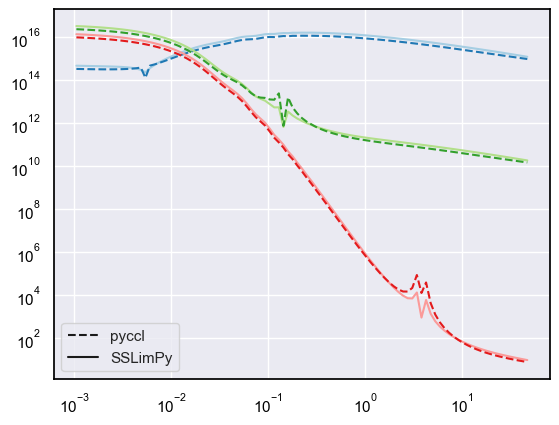

In [34]:
colors = iter(C)

plt.loglog(k, T_2211_A_SL[:,15], c=next(colors))
plt.loglog(k, T_2211_A_CL[:,15], c=next(colors), ls="--")
plt.loglog(k, T_2211_A_SL[:,45], c=next(colors))
plt.loglog(k, T_2211_A_CL[:,45], c=next(colors), ls="--")
plt.loglog(k, T_2211_A_SL[:,75], c=next(colors))
plt.loglog(k, T_2211_A_CL[:,75], c=next(colors), ls="--")

plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")
plt.legend()

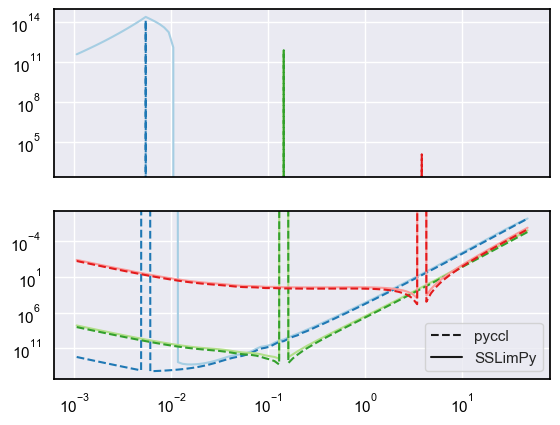

In [35]:
colors = iter(C)

fig, axs = plt.subplots(2, 1, sharex=True)

indicies = [15, 45, 75]
for i in indicies:
    c = next(colors)
    axs[0].loglog(k, T_2211_X_SL[:,i], c=c)
    axs[1].loglog(k, -T_2211_X_SL[:,i], c=c)

    c = next(colors)
    axs[0].loglog(k, T_2211_X_CL[:,i], c=c, ls="--")
    axs[1].loglog(k, -T_2211_X_CL[:,i], c=c, ls="--")

axs[1].invert_yaxis()
plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")

plt.legend()

In [36]:
T_2211_SL = T_2211_A_SL + T_2211_X_SL
T_2211_CC = T_2211_A_CL + T_2211_X_CL

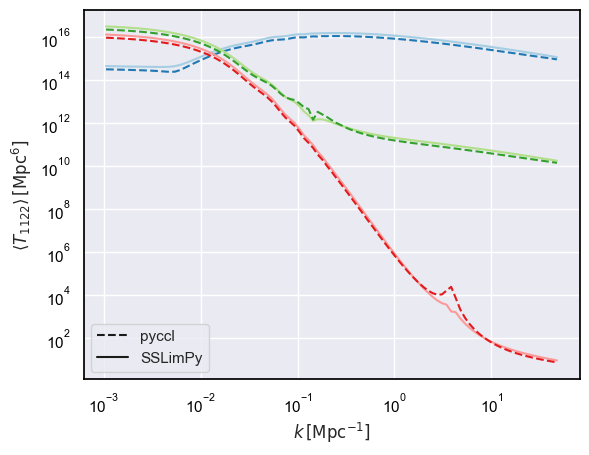

In [37]:
colors = iter(C)

plt.loglog(k, T_2211_SL[:,15], c=next(colors), ls="-")
plt.loglog(k, T_2211_CC[:,15], c=next(colors), ls="--")

plt.loglog(k, T_2211_SL[:,45], c=next(colors), ls="-")
plt.loglog(k, T_2211_CC[:,45], c=next(colors), ls="--")

plt.loglog(k, T_2211_SL[:,75], c=next(colors), ls="-")
plt.loglog(k, T_2211_CC[:,75], c=next(colors), ls="--")

plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T_{1122} \rangle\,[\mathrm{Mpc}^6]$")

plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")
plt.legend()


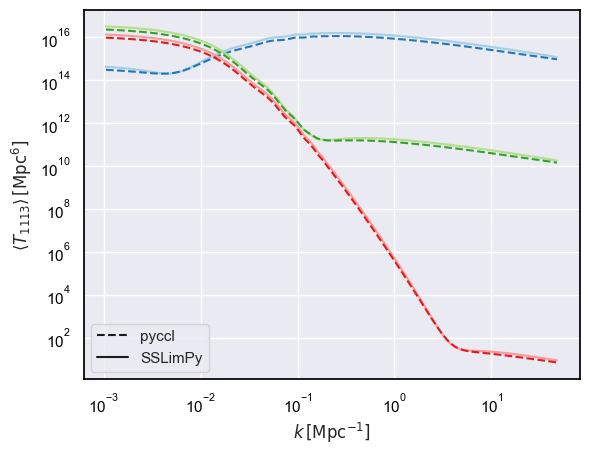

In [38]:
colors = iter(C)

plt.loglog(k, -T_3111_SL[:,15], c=next(colors), ls="-")
plt.loglog(k, -T_3111_CC[:,15], c=next(colors), ls="--")

plt.loglog(k, -T_3111_SL[:,45], c=next(colors), ls="-")
plt.loglog(k, -T_3111_CC[:,45], c=next(colors), ls="--")

plt.loglog(k, -T_3111_SL[:,75], c=next(colors), ls="-")
plt.loglog(k, -T_3111_CC[:,75], c=next(colors), ls="--")

plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T_{1113} \rangle\,[\mathrm{Mpc}^6]$")

plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")
plt.legend()


# Full expression

In [39]:
# F = np.loadtxt("CCL_Trispectrum.txt")
T_CC = T_2211_X_CL + T_2211_A_CL + T_3111_CC
T_SL = T_2211_X_SL.value + T_2211_A_SL.value + T_3111_SL.value

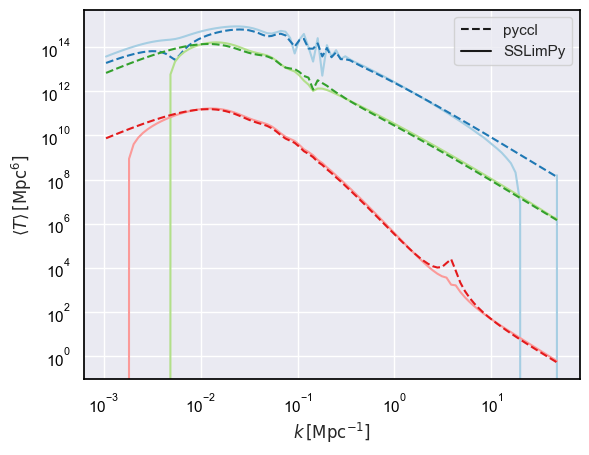

In [40]:
colors = iter(C)

plt.loglog(k, T_SL[:, 15], c=next(colors))
plt.loglog(k, T_CC[:, 15], c=next(colors), ls="--")

plt.loglog(k, T_SL[:, 45], c=next(colors))
plt.loglog(k, T_CC[:, 45], c=next(colors), ls="--")

plt.loglog(k, T_SL[:, 75], c=next(colors))
plt.loglog(k, T_CC[:, 75], c=next(colors), ls="--")

plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T \rangle\,[\mathrm{Mpc}^6]$")

plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")
plt.legend()

In [41]:
T_CC = np.loadtxt("/home/sefa/Desktop/LIM-Code/SSLimPy/CCL_Trispectrum.txt")

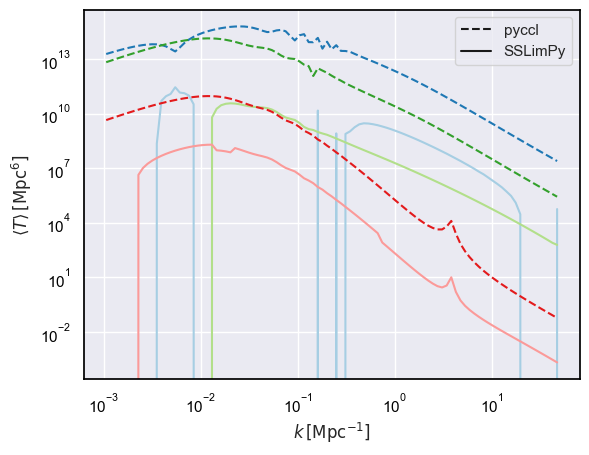

In [42]:
colors = iter(C)

plt.loglog(k, a[:, 15, 0, 0], c=next(colors))
plt.loglog(k, T_CC[:, 15], c=next(colors), ls="--")

plt.loglog(k, a[:, 45, 0, 0], c=next(colors))
plt.loglog(k, T_CC[:, 45], c=next(colors), ls="--")

plt.loglog(k, a[:, 75, 0, 0], c=next(colors))
plt.loglog(k, T_CC[:, 75], c=next(colors), ls="--")

plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T \rangle\,[\mathrm{Mpc}^6]$")

plt.loglog([],[], "k--", label="pyccl")
plt.loglog([],[], "k-", label="SSLimPy")
plt.legend()